<a href="https://colab.research.google.com/github/carlos-ochoa/ML_Notebooks/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Kaggle Competition

I've already tried this competition some months ago when I was starting my journey in machine learning, then I got about 66% of accuracy, my goal this time is to beat at least 85%

This is the link for this Kaggle competition: https://www.kaggle.com/c/titanic/overview


In [ ]:
# First of all I'm gonna load every module that could be useful for this

! pip install gplearn

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from gplearn.genetic import SymbolicClassifier, SymbolicTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint


Displaying training dataset



In [ ]:
path = 'drive/My Drive/Competencias Kaggle/Titanic/'

train_dataset = pd.read_csv(path+'train.csv')
test_dataset = pd.read_csv(path+'test.csv') 

display(train_dataset)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Let's remember what every column is saying. Extracted from the official competition web.

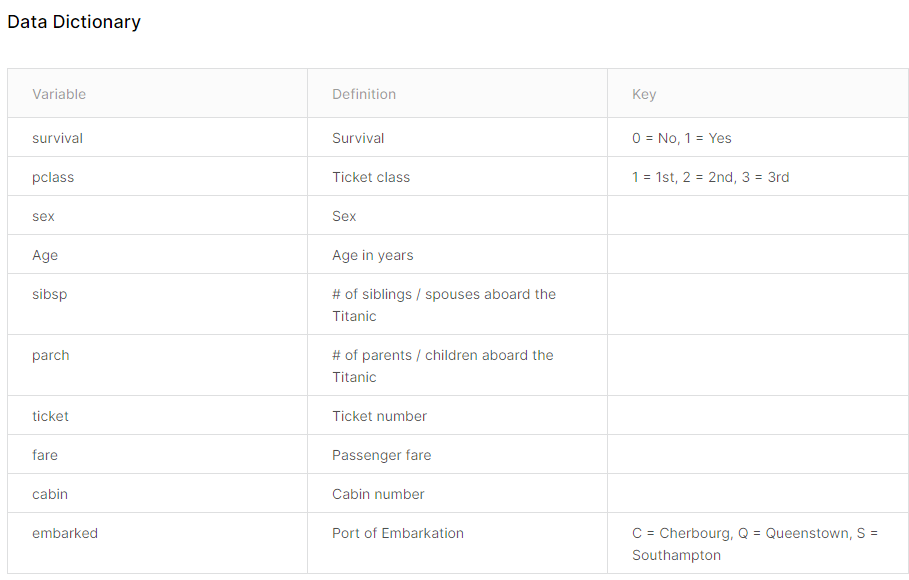

## Data preparation step

Well, it's time to prepare our data, in order to be useful for machine learning models! I'm gonna explain each prep technique I use.

As we can see it seems to be a lot of missing data, specially in features like cabin, I'm going to **impute the data** so as to keep integrity or at least try to.

In this ocassion I use the **KNNImputer** because I believe it is a good imputing technique for this kind of data. This dataset has some missing values in numerical features like age, sibsp, parch and fare. All of them would not be well shaped by mean or most-frequent techniques because every passenger in the Titanic and its features rely only on people who is similar.
For instance, having a person who is in 1st class with fare missing. Fare can't be imputed taking into account information from every passenger in the ship, because there are people on 2nd and 3rd class. It would have more sense to impute fare with fare of people who is similar to this person in features i.e. people of first class. This is also applicable to categorical data.

KNNImputer uses KNN technique and imputes missing data by taking the one of the similar neighbors, so it keeps consistency of the imputed data.

## Erasing not useful data

Sometimes some features are not useful or they need to be transformed in order to help us. So, before imputing data I'm gonna choose which information seems to be useful. I'll do this later again but by analyzing data, for now I'm checking categorical features to drop the ones that are not useful and don't require further analysis.

## Label-encoding

I need to impute the data with the KNNImputer, nevertheless it allows only numerical data, so I need to encode categorical features with the LabelEncoder

In [ ]:
lbl, lbl2, lbl3, lbl4 = LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder()

titles = [name.split(',')[1].split()[0][:-1] for name in train_dataset['Name'].fillna('-')]
titles_test = [name.split(',')[1].split()[0][:-1] for name in test_dataset['Name'].fillna('-')]

print(set(titles + titles_test))

lbl2.fit(list(set(titles + titles_test)))

# Erasing data that is not useful
def preprocess_data(dataset, train = True):
  # Name is not a useful feature, it has no impact on surviving, nevertheless the title could be useful, it provides more information about social status
  titles = [name.split(',')[1].split()[0][:-1] for name in dataset['Name'].fillna('-')]

  # Cabin number doesn't provide much info, but it gives the deck where the cabin was located, that position could be useful
  decks = []

  for cabin in dataset['Cabin']:
    if isinstance(cabin, float):
      decks.append('NaN')
    else:
      decks.append(cabin[0])

  # Creating the new dataframe with categorical values
  data = {'title' : titles, 'class' : dataset['Pclass'], 'sex' : dataset['Sex'], 'age' : dataset['Age'], \
          'sibsp' : dataset['SibSp'], 'parch' : dataset['Parch'], \
          'deck' : decks, 'fare' : dataset['Fare'], 'embarked' : dataset['Embarked'].fillna('NaN')}
  
  if train:
    data['survived'] = dataset['Survived']

  else:
    data['survived'] = [0 for n in range(len(dataset.index))]

  data = pd.DataFrame(data = data)

  if train:

    # Encoding data 

    sex_labels = list(lbl.fit_transform(data['sex']))
    title_labels = list(lbl2.transform(data['title']))
    deck_labels = list(lbl3.fit_transform(data['deck']))
    embarked_labels = list(lbl4.fit_transform(data['embarked']))

  else: 
    sex_labels = list(lbl.transform(data['sex']))
    title_labels = list(lbl2.transform(data['title']))
    deck_labels = list(lbl3.transform(data['deck']))
    embarked_labels = list(lbl4.transform(data['embarked']))

  data['sex'] = sex_labels
  data['title'] = title_labels
  data['deck'] = deck_labels
  data['embarked'] = embarked_labels

  print(lbl3.classes_)
  print(lbl4.classes_)

  # Converting NaN to be used for the imputer

  data['deck'].replace(7,np.nan, inplace = True)
  data['embarked'].replace(1,np.nan, inplace = True)

  return data

train_data = preprocess_data(train_dataset)

display(train_data)

{'Sir', 'th', 'Jonkheer', 'Mr', 'Mlle', 'Ms', 'Capt', 'Dona', 'Rev', 'Col', 'Master', 'Mrs', 'Mme', 'Lady', 'Miss', 'Dr', 'Don', 'Major'}
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'NaN' 'T']
['C' 'NaN' 'Q' 'S']


,title,class,sex,age,sibsp,parch,deck,fare,embarked,survived
0,12,3,1,22.0,1,0,NaN,7.2500,3.0,0
1,13,1,0,38.0,1,0,2.0,71.2833,0.0,1
2,9,3,0,26.0,0,0,NaN,7.9250,3.0,1
3,13,1,0,35.0,1,0,2.0,53.1000,3.0,1
4,12,3,1,35.0,0,0,NaN,8.0500,3.0,0
...,...,...,...,...,...,...,...,...,...,...
886,15,2,1,27.0,0,0,NaN,13.0000,3.0,0
887,9,1,0,19.0,0,0,1.0,30.0000,3.0,1
888,9,3,0,NaN,1,2,NaN,23.4500,3.0,0
889,12,1,1,26.0,0,0,2.0,30.0000,0.0,1


## Deleting outliers

There are some rows that could contain outliers, so as not to iontroduce noise in the data it's a good idea to delete them. To do that, I'll delete everything that is beyond three standard deviations.

## Normalization

Outliers were deleted, so I can use the MinMaxScaler from sklearn.

## Decoding the data to be read as categorical variable

In order to use this dataframe to feed algorithms that allow categorical variables I'm going to decode the data, later I'm going to encode it as **one-hot** to feed numerical algorithms.

In [ ]:
imputer = KNNImputer(n_neighbors = 6, weights="uniform")
scaler = MinMaxScaler()

def engineering_data(data, train = True):

  if train:
    # Data imputation for numerical values
    data_imputed = imputer.fit_transform(data)

    data = pd.DataFrame(data = data_imputed, columns = data.columns).round()

    # Deleting outliers

    z_scores = zscore(data)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    data = data[filtered_entries]
  
  else: 
    data_imputed = imputer.transform(data)

    data = pd.DataFrame(data = data_imputed, columns = data.columns).round()

  # Normalization
  if train :
    data['age'] = scaler.fit_transform(data[['age']])
    data['fare'] = scaler.fit_transform(data[['fare']])

  else:
    data['age'] = scaler.transform(data[['age']])
    data['fare'] = scaler.transform(data[['fare']])

  # Decoding to categorical values

  #data['sex'] = list(lbl.inverse_transform(data['sex'].astype('int32')))
  #data['title'] = list(lbl2.inverse_transform(data['title'].astype('int32')))
  #data['deck'] = list(lbl3.inverse_transform(data['deck'].astype('int32')))
  #data['embarked'] = list(lbl4.inverse_transform(data['embarked'].astype('int32')))

  return data

train_data = engineering_data(train_data)
# train_data will be used for categorical learning models, in order to simplify it
display(train_data)



,title,class,sex,age,sibsp,parch,deck,fare,embarked,survived
0,12.0,3.0,1.0,0.309859,1.0,0.0,5.0,0.042424,3.0,0.0
1,13.0,1.0,0.0,0.535211,1.0,0.0,2.0,0.430303,0.0,1.0
2,9.0,3.0,0.0,0.366197,0.0,0.0,5.0,0.048485,3.0,1.0
3,13.0,1.0,0.0,0.492958,1.0,0.0,2.0,0.321212,3.0,1.0
4,12.0,3.0,1.0,0.492958,0.0,0.0,4.0,0.048485,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,15.0,2.0,1.0,0.380282,0.0,0.0,5.0,0.078788,3.0,0.0
887,9.0,1.0,0.0,0.267606,0.0,0.0,1.0,0.181818,3.0,1.0
888,9.0,3.0,0.0,0.112676,1.0,2.0,4.0,0.139394,3.0,0.0
889,12.0,1.0,1.0,0.366197,0.0,0.0,2.0,0.181818,0.0,1.0


## Data exploration 

We have to explore visually the data in order to find interesting relations that could help us to create new features before training the model



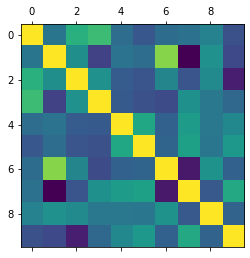

,title,class,sex,age,sibsp,parch,deck,fare,embarked,survived
title,1.000000,-0.041004,0.378823,0.465365,-0.093893,-0.237707,-0.098440,-0.057529,0.053041,-0.279068
class,-0.041004,1.000000,0.146253,-0.364834,-0.051644,-0.088297,0.692688,-0.697522,0.158605,-0.324000
sex,0.378823,0.146253,1.000000,0.159344,-0.206345,-0.252039,0.077274,-0.250007,0.116890,-0.557235
age,0.465365,-0.364834,0.159344,1.000000,-0.213936,-0.274454,-0.306376,0.152633,-0.016683,-0.127920
sibsp,-0.093893,-0.051644,-0.206345,-0.213936,1.000000,0.311473,-0.170425,0.234733,-0.019628,0.096353
parch,-0.237707,-0.088297,-0.252039,-0.274454,0.311473,1.000000,-0.151320,0.267597,-0.027906,0.204294
deck,-0.098440,0.692688,0.077274,-0.306376,-0.170425,-0.151320,1.000000,-0.581629,0.177719,-0.172682
fare,-0.057529,-0.697522,-0.250007,0.152633,0.234733,0.267597,-0.581629,1.000000,-0.226592,0.328714
embarked,0.053041,0.158605,0.116890,-0.016683,-0.019628,-0.027906,0.177719,-0.226592,1.000000,-0.156498
survived,-0.279068,-0.324000,-0.557235,-0.127920,0.096353,0.204294,-0.172682,0.328714,-0.156498,1.000000


In [ ]:
plt.matshow(train_data.corr(method = 'pearson'))
plt.show()

train_data.corr(method = 'pearson')

We can see some relationships between features like class and fare or sibsp and parch, I only find the last relation useful, I can collapse those two features in a single one called 'alone' with 1 for traveling without sibsp or parch. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0886277f0>,
      dtype=object)

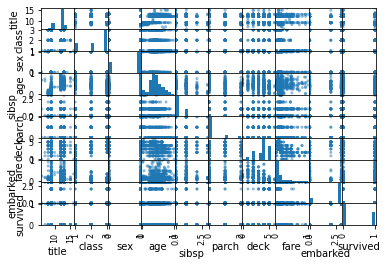

In [ ]:
pd.plotting.scatter_matrix(train_data)

No outliers detected anymore

In [ ]:
def traveling_alone(row):
  if row['sibsp'] == 0 and row['parch'] == 0:
    return 1
  else :
    return 0

def drop_features(data):
  data['alone'] = data.apply(lambda row : traveling_alone(row), axis = 1 )

  data.drop(columns = ['sibsp', 'parch'], inplace = True)

  # One-hot encoding
  data_num = pd.get_dummies(data)

  return data, data_num

train_data, train_data_num = drop_features(train_data)

# train_data_num will be used for numerical learning methods
display(train_data_num)

display(train_data)

,title,class,sex,age,deck,fare,embarked,survived,alone
0,12.0,3.0,1.0,0.309859,5.0,0.042424,3.0,0.0,0
1,13.0,1.0,0.0,0.535211,2.0,0.430303,0.0,1.0,0
2,9.0,3.0,0.0,0.366197,5.0,0.048485,3.0,1.0,1
3,13.0,1.0,0.0,0.492958,2.0,0.321212,3.0,1.0,0
4,12.0,3.0,1.0,0.492958,4.0,0.048485,3.0,0.0,1
...,...,...,...,...,...,...,...,...,...
886,15.0,2.0,1.0,0.380282,5.0,0.078788,3.0,0.0,1
887,9.0,1.0,0.0,0.267606,1.0,0.181818,3.0,1.0,1
888,9.0,3.0,0.0,0.112676,4.0,0.139394,3.0,0.0,0
889,12.0,1.0,1.0,0.366197,2.0,0.181818,0.0,1.0,1


,title,class,sex,age,deck,fare,embarked,survived,alone
0,12.0,3.0,1.0,0.309859,5.0,0.042424,3.0,0.0,0
1,13.0,1.0,0.0,0.535211,2.0,0.430303,0.0,1.0,0
2,9.0,3.0,0.0,0.366197,5.0,0.048485,3.0,1.0,1
3,13.0,1.0,0.0,0.492958,2.0,0.321212,3.0,1.0,0
4,12.0,3.0,1.0,0.492958,4.0,0.048485,3.0,0.0,1
...,...,...,...,...,...,...,...,...,...
886,15.0,2.0,1.0,0.380282,5.0,0.078788,3.0,0.0,1
887,9.0,1.0,0.0,0.267606,1.0,0.181818,3.0,1.0,1
888,9.0,3.0,0.0,0.112676,4.0,0.139394,3.0,0.0,0
889,12.0,1.0,1.0,0.366197,2.0,0.181818,0.0,1.0,1


## Training classifiers

I will try models like **Decision Trees, KNN, Random Forest, Neural Networks and Symbolic Evolutionary Classifiers**, because I think those are simple models than could shape accurately this dataset, which doesn't have a lot of samples. For every model I will try hyper-parameter tuning except NN, because its performance at this task was not as good as the others'. 

In [ ]:
survived = train_data['survived']
train_data.drop(columns = ['survived'], inplace = True)
train_data_num.drop(columns = ['survived'], inplace = True)

test_data = preprocess_data(test_dataset, train = False)
test_data = engineering_data(test_data, train = False)
test_data, test_data_num = drop_features(test_data)
test_data.drop(columns = ['survived'], inplace = True)
test_data_num.drop(columns = ['survived'], inplace = True)

survived1 = survived.iloc[:711]
surv_pred = survived.iloc[711:]
train_data1 = train_data.iloc[:711,:]
validation_data = train_data.iloc[711:,:]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'NaN' 'T']
['C' 'NaN' 'Q' 'S']


In [ ]:
tree_params = {
    'criterion' : ['gini','entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : randint(1,10),
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_leaf' : uniform(0.05, 0.1)
}

tree = DecisionTreeClassifier()

clf_tree = RandomizedSearchCV(tree, tree_params, n_iter = 100, cv = 5)

#knn.fit(train_data1, survived1)

clf_tree.fit(train_data1, survived1)

predictions = clf_tree.predict(validation_data)
print(metrics.accuracy_score(surv_pred, predictions))
print(metrics.confusion_matrix(surv_pred, predictions))
#knn.get_params()

from pprint import pprint
pprint(clf_tree.best_estimator_.get_params())

0.79
[[46 16]
 [ 5 33]]
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.07342609517533873,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}


In [ ]:
tree_params = {
    'criterion' : ['gini','entropy'],
    'max_depth' : randint(1,10),
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_leaf' : uniform(0.05, 0.1)
}

tree = RandomForestClassifier()

clf_tree = RandomizedSearchCV(tree, tree_params, n_iter = 100, cv = 5)

#knn.fit(train_data1, survived1)

clf_tree.fit(train_data1, survived1)

predictions = clf_tree.predict(validation_data)
print(metrics.accuracy_score(surv_pred, predictions))
print(metrics.confusion_matrix(surv_pred, predictions))
#knn.get_params()

from pprint import pprint
pprint(clf_tree.best_estimator_.get_params())

0.81
[[56  6]
 [13 25]]
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.06404825925787642,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
knn_params = {
    'n_neighbors' : randint(1,50),
    'leaf_size' : randint(1,100),
    'p' : randint(1,20),
    'weights' : ['uniform', 'distance']
}

knn = KNeighborsClassifier()

clf_knn = RandomizedSearchCV(knn, knn_params, n_iter = 100, cv = 5)

#knn.fit(train_data1, survived1)

clf_knn.fit(train_data1, survived1)

predictions = clf_knn.predict(validation_data)
print(metrics.accuracy_score(surv_pred, predictions))
print(metrics.confusion_matrix(surv_pred, predictions))
#knn.get_params()

from pprint import pprint
pprint(clf_knn.best_estimator_.get_params())

0.81
[[55  7]
 [12 26]]
{'algorithm': 'auto',
 'leaf_size': 38,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 6,
 'p': 17,
 'weights': 'uniform'}


In [ ]:
sym_params = {
    'population_size' : randint(200,1000),
    'generations' : randint(20,30),
    'tournament_size' : randint(5,30),
    'init_method' : ['grow', 'full', 'half and half'],
    'function_set' : [('add','sub','mul','div','log','sqrt','inv','cos')],
    'parsimony_coefficient' : uniform(0.001, 0.009),
}

sym = SymbolicClassifier()

clf_sym = RandomizedSearchCV(sym, sym_params, n_iter = 10, cv = 5)

#knn.fit(train_data1, survived1)

clf_sym.fit(train_data1, survived1)

predictions = clf_sym.predict(validation_data)
print(metrics.accuracy_score(surv_pred, predictions))
print(metrics.confusion_matrix(surv_pred, predictions))
#knn.get_params()

from pprint import pprint
pprint(clf_sym.best_estimator_.get_params())

0.8
[[55  7]
 [13 25]]
{'const_range': (-1.0, 1.0),
 'feature_names': None,
 'function_set': ('add', 'sub', 'mul', 'div', 'log', 'sqrt', 'inv', 'cos'),
 'generations': 28,
 'init_depth': (2, 6),
 'init_method': 'grow',
 'low_memory': False,
 'max_samples': 1.0,
 'metric': 'log loss',
 'n_jobs': 1,
 'p_crossover': 0.9,
 'p_hoist_mutation': 0.01,
 'p_point_mutation': 0.01,
 'p_point_replace': 0.05,
 'p_subtree_mutation': 0.01,
 'parsimony_coefficient': 0.005966857492961746,
 'population_size': 684,
 'random_state': None,
 'stopping_criteria': 0.0,
 'tournament_size': 15,
 'transformer': 'sigmoid',
 'verbose': 0,
 'warm_start': False}


In [ ]:
epochs = 170

nn = kr.models.Sequential([
  kr.layers.Dense(units = 40, activation = 'tanh'),
  kr.layers.Dense(units = 40, activation = 'tanh'),
  kr.layers.Dense(units = 100, activation = 'tanh'),
  kr.layers.Dense(units = 40, activation = 'tanh'),
  kr.layers.Dense(units = 1, activation = 'sigmoid')
])

adam = kr.optimizers.Adam(learning_rate=0.0015, beta_1=0.7, beta_2=0.9)

nn.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = nn.fit(train_data, survived, epochs = epochs, verbose = 2, batch_size=8, validation_split = 0.1)
predictions = nn.predict(test_data)
predictions = np.where(predictions > 0.5, 1, 0)

plt.plot(range(0,epochs),history.history['accuracy'])
plt.plot(range(0,epochs),history.history['val_accuracy'])
plt.plot(range(0,epochs),history.history['val_loss'])
plt.plot(range(0,epochs),history.history['loss'])
plt.show()

Individually, the best classifier is KNN with 74% of accuracy, let's use and ensemble method with a voting classifier using our 3 best models: KNN, Random forest and Symbolic Classifier.

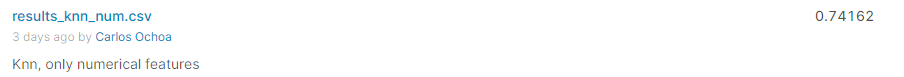

In [ ]:
vtg = VotingClassifier(estimators = [('knn', clf_knn), ('rf', clf_tree),('sym', clf_sym)], voting = 'hard')
vtg.fit(train_data, survived)
predictions = vtg.predict(validation_data)
print(metrics.accuracy_score(surv_pred, predictions))
print(metrics.confusion_matrix(surv_pred, predictions))

0.86
[[55  7]
 [ 7 31]]


We write the results in a csv

In [ ]:
rows = [i for i in range(892,1310)]
predictions = vtg.predict(test_data)
predictions = predictions.reshape(1,418).flatten()
results = {'PassengerId' : rows, 'Survived' : predictions.astype('int32')}
results = pd.DataFrame(results)
results.to_csv('results_vtg.csv', index = False)
display(results)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Finally, the best result was gotten by a Voting classifier with 77% of accuracy

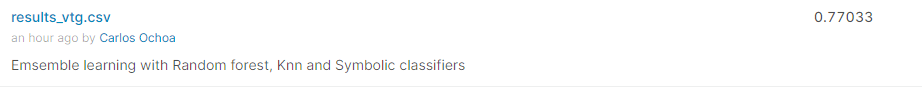

## Future work ##

There are more techniques I didn't use but they could be useful to improve the performance of the models. 
Data augmentation could be useful, there are only 811 examples in the training dataset, it is probably why every model was stuck around 70%-80% accuracy at the test set and around 84% at the validation set. Getting more data could build better aproaches. 

I also used a Symbolic Transformer to get more interesting features but it wasn't really useful. Probably there could be some features generated by automated techniques but, for now it is beyond my experience.